O arquivo utilizado neste projeto pode ser encontrado em: https://www.kaggle.com/datasets/jihyeseo/online-retail-data-set-from-uci-ml-repo


In [ ]:
# Carregando biblioteca e pacotes
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Carregando dataset

retail = pd.read_excel(r"C:\Users\luans\Workspace\projetos_pessoais\Untitled Folder\cohort\Online Retail.xlsx")

# Exibe primeiras linhas do dataset

retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Da primeira à última coluna do dataset temos: cod numérico de identificação da compra, cod numérico de identificação do item, descrição do item, quantidade comprada, data de compra, preço unitário, chave numérica de identificação do consumidor e país da compra.

Para acompanhar o comportamento de determinado cliente ao longo do tempo precisamos que a variavel CustomerId esteja preenchida, por isso vamos excluir linhas que não possuem essa variável "CustomerID" preenchida.

In [3]:
retail.dropna(subset=['CustomerID'], inplace=True)

Aqui verificamos um ponto preocupante no dataset,perdemos cerca de 25% das linhas no dataset.Como nesse caso não temos muita ação sobre este problema, vamos apenas dar sequência.

Vamos realizar entender um pouco nossos dados antes de gerar as cohorts.

In [4]:
# Estatistica descritiva

retail.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,406829.000000,406829,406829.000000,406829.000000
mean,12.061303,2011-07-10 16:30:57.879207424,3.460471,15287.690570
min,-80995.000000,2010-12-01 08:26:00,0.000000,12346.000000
25%,2.000000,2011-04-06 15:02:00,1.250000,13953.000000
50%,5.000000,2011-07-31 11:48:00,1.950000,15152.000000
75%,12.000000,2011-10-20 13:06:00,3.750000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,248.693370,NaN,69.315162,1713.600303


Aqui a média de itens por compras é em torno de 12, enquanto a mediana indica 5. Isso mostra que temos uma distribuição bastante assimétrica.

Vamos entender a visão do consumidor, como será que é a distribuição de compras feitas pelos clientes? Quantas compras cada cliente fez?

Vamos contar quantos invoices cada cliente tem:

In [5]:
retail.groupby(['CustomerID'])['InvoiceNo'].nunique().sort_values()

CustomerID
15300.0      1
13833.0      1
16123.0      1
13829.0      1
13828.0      1
          ... 
13089.0    118
14606.0    128
17841.0    169
12748.0    224
14911.0    248
Name: InvoiceNo, Length: 4372, dtype: int64

In [6]:
invoice_per_customer = retail.groupby(['CustomerID'])['InvoiceNo'].nunique()

invoice_per_customer.describe()

count    4372.000000
mean        5.075480
std         9.338754
min         1.000000
25%         1.000000
50%         3.000000
75%         5.000000
max       248.000000
Name: InvoiceNo, dtype: float64

Vemos que há muitos clientes com poucas compras e poucos clientes com muitas compras, claramente assimétrica a distribuição de invoices pelos consumidores. Vamos fazer um histograma para verificar esse comportamento.

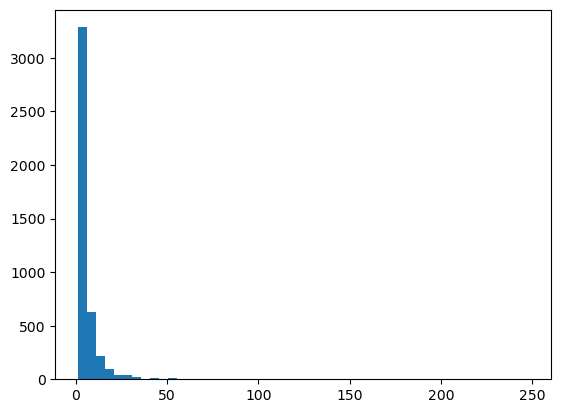

In [7]:
_=plt.hist(invoice_per_customer, bins=50)

É bem sutil, mas existem consumidores com 50, 100 e até 200 compras. Mas a maioria está entre 0 e 5 compras.

Com isso podemos esperar pouca retenção.Vamos seguir para a Análise de Cohort. Para isso vamos agrupar pela chave de identificação do cliente, a chave de identificação da compra e a data da compra:


In [8]:
# Primeira limpeza: Remover duplicidades

retail = retail[['CustomerID', 'InvoiceNo', 'InvoiceDate']].drop_duplicates()

# Vamos organizar por meses

retail['InvoiceMonth'] = retail['InvoiceDate'].dt.to_period('M')

# Vamos pegar o primeiro mes de compra, ou seja, a entrada do cliente

retail['Cohort'] = retail.groupby('CustomerID')['InvoiceDate'].transform('min').dt.to_period('M')
retail.head()

,CustomerID,InvoiceNo,InvoiceDate,InvoiceMonth,Cohort
0,17850.0,536365,2010-12-01 08:26:00,2010-12,2010-12
7,17850.0,536366,2010-12-01 08:28:00,2010-12,2010-12
9,13047.0,536367,2010-12-01 08:34:00,2010-12,2010-12
21,13047.0,536368,2010-12-01 08:34:00,2010-12,2010-12
25,13047.0,536369,2010-12-01 08:35:00,2010-12,2010-12


In [9]:
# Agora vamos agrupar por cohort e por mês de Invoice

retail_cohort = retail.groupby(['Cohort', 'InvoiceMonth']).agg(n_customers=('CustomerID', 'nunique')).reset_index(drop=False)
retail_cohort.head()

,Cohort,InvoiceMonth,n_customers
0,2010-12,2010-12,948
1,2010-12,2011-01,362
2,2010-12,2011-02,317
3,2010-12,2011-03,367
4,2010-12,2011-04,341


Para facilitar a construção da matriz vamos calcular o periodo e criar uma coluna com ele, por exemplo se a cohor se iniciou em dezembro de 2010, o mês de janeiro de 2011 será o número 1, fevereiro será 2 e assim por diante

In [10]:
# Calcular o periodo em meses
retail_cohort['Period'] = (retail_cohort['InvoiceMonth'].dt.year - retail_cohort['Cohort'].dt.year) * 12 + (retail_cohort['InvoiceMonth'].dt.month - retail_cohort['Cohort'].dt.month)
retail_cohort.head()

,Cohort,InvoiceMonth,n_customers,Period
0,2010-12,2010-12,948,0
1,2010-12,2011-01,362,1
2,2010-12,2011-02,317,2
3,2010-12,2011-03,367,3
4,2010-12,2011-04,341,4


In [11]:
# Criar uma tabela dinamica

cohort_pivot = retail_cohort.pivot_table(index='Cohort', columns='Period', values='n_customers')
cohort_pivot

Period,0,1,2,3,4,5,6,7,8,9,10,11,12
Cohort,,,,,,,,,,,,,
2010-12,948.0,362.0,317.0,367.0,341.0,376.0,360.0,336.0,336.0,374.0,354.0,474.0,260.0
2011-01,421.0,101.0,119.0,102.0,138.0,126.0,110.0,108.0,131.0,146.0,155.0,63.0,NaN
2011-02,380.0,94.0,73.0,106.0,102.0,94.0,97.0,107.0,98.0,119.0,35.0,NaN,NaN
2011-03,440.0,84.0,112.0,96.0,102.0,78.0,116.0,105.0,127.0,39.0,NaN,NaN,NaN
2011-04,299.0,68.0,66.0,63.0,62.0,71.0,69.0,78.0,25.0,NaN,NaN,NaN,NaN
2011-05,279.0,66.0,48.0,48.0,60.0,68.0,74.0,29.0,NaN,NaN,NaN,NaN,NaN
2011-06,235.0,49.0,44.0,64.0,58.0,79.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,191.0,40.0,39.0,44.0,52.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,167.0,42.0,42.0,42.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# Pegar os valores da primeira coluna

cohort_size = cohort_pivot.iloc[:,0]
cohort_size

Cohort
2010-12    948.0
2011-01    421.0
2011-02    380.0
2011-03    440.0
2011-04    299.0
2011-05    279.0
2011-06    235.0
2011-07    191.0
2011-08    167.0
2011-09    298.0
2011-10    352.0
2011-11    321.0
2011-12     41.0
Freq: M, Name: 0, dtype: float64

In [13]:
# Realizar a divisão dos números das outras colunas pelo valor da primeira coluna de sua linha.

retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)
retention_matrix

Period,0,1,2,3,4,5,6,7,8,9,10,11,12
Cohort,,,,,,,,,,,,,
2010-12,1.0,0.381857,0.334388,0.387131,0.359705,0.396624,0.379747,0.354430,0.354430,0.394515,0.373418,0.500000,0.274262
2011-01,1.0,0.239905,0.282660,0.242280,0.327791,0.299287,0.261283,0.256532,0.311164,0.346793,0.368171,0.149644,NaN
2011-02,1.0,0.247368,0.192105,0.278947,0.268421,0.247368,0.255263,0.281579,0.257895,0.313158,0.092105,NaN,NaN
2011-03,1.0,0.190909,0.254545,0.218182,0.231818,0.177273,0.263636,0.238636,0.288636,0.088636,NaN,NaN,NaN
2011-04,1.0,0.227425,0.220736,0.210702,0.207358,0.237458,0.230769,0.260870,0.083612,NaN,NaN,NaN,NaN
2011-05,1.0,0.236559,0.172043,0.172043,0.215054,0.243728,0.265233,0.103943,NaN,NaN,NaN,NaN,NaN
2011-06,1.0,0.208511,0.187234,0.272340,0.246809,0.336170,0.102128,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,1.0,0.209424,0.204188,0.230366,0.272251,0.115183,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,1.0,0.251497,0.251497,0.251497,0.137725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


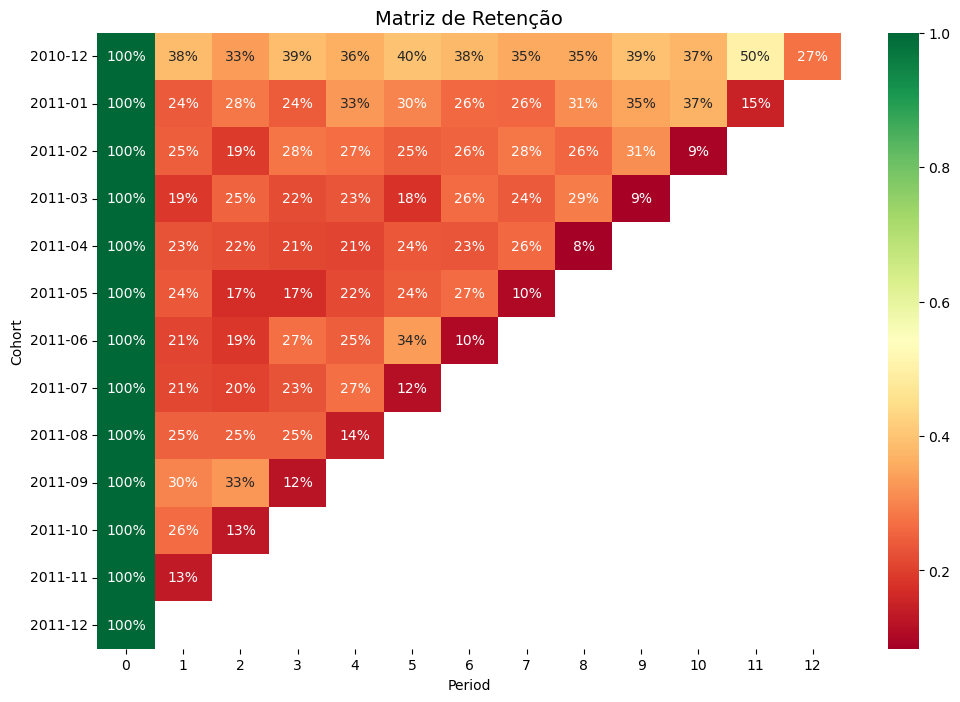

In [14]:
# Construir mapa de calor
_=plt.subplots(figsize=(12, 8))

_= sns.heatmap(
    data = retention_matrix,
    mask = retention_matrix.isnull(),
    annot = True,
    fmt = '.0%',
    cmap = 'RdYlGn'
)

_ = plt.title('Matriz de Retenção', size=14)

De acordo com a análise realizada conseguimos chegar as seguintes conclusões:

Queda de Retenção ao Longo do Tempo: É visível que a retenção dos clientes diminui consistentemente à medida que o período avança. Isso é comum em análises de cohort, pois a maioria dos clientes tende a se engajar mais no início e depois perde interesse ou não retorna.

Melhor Cohort (2010-12): A cohort de dezembro de 2010 mostra uma retenção relativamente alta em comparação com as outras, especialmente nos períodos iniciais e novamente no período 11 (com 50%). Isso pode indicar que campanhas ou produtos lançados nessa época foram mais eficazes em manter o interesse dos clientes.

Dificuldades de Retenção em Cohorts Posteriores: A partir de abril de 2011, a retenção parece declinar de forma mais acentuada, especialmente nos períodos intermediários (períodos 4 a 6). A cohort de novembro de 2011, por exemplo, mostra uma queda drástica, com retenção já muito baixa no segundo período (13%).

Possível Efeito Sazonal: Alguns picos de retenção podem indicar efeitos sazonais ou campanhas específicas que foram mais bem-sucedidas em determinados meses, como o aumento de retenção observado no nono período da cohort de dezembro de 2010.

Oportunidade de Intervenção: Intervenções podem ser necessárias para os cohorts de meados de 2011, onde a retenção é baixa em períodos iniciais. Entender por que a retenção caiu tanto nesses períodos pode ser crucial para melhorar futuras campanhas ou estratégias.

Revisão de Estratégias de Engajamento: Para os cohorts onde a retenção caiu drasticamente após o primeiro ou segundo período, pode ser interessante revisar as estratégias de retenção e engajamento implementadas, para identificar o que está causando a perda rápida de clientes.